# Generate Synthetic Biometric Performance Data

In [9]:
import pandas as pd        # data wrangling
import numpy as np         # numerical computation
import matplotlib.pyplot as plt  # static plots
import seaborn as sns      # statistical visualization

print("✓ Libraries imported")

✓ Libraries imported


In [10]:
# Set random seed for reproducibility
np.random.seed(42)

print("Generating synthetic biometric performance data...")
print("(Simulating FaceNet performance patterns observed in NIST FRVT studies)\n")

# Demographics
# supervised learning: real faces annotated by humans suggesting that race is considered in algorithm
# if the algorithm considers race, that is an issue
# unlikely that the algorithm doesn't conduct a racial bin to reduce runtime but not sure
races = ['White', 'Black', 'Latino_Hispanic', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern']
genders = ['Male', 'Female']
ages = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Generate data
n_pairs_per_group = 100
data = []

# Simulate realistic performance patterns based on NIST FRVT findings
# REVISED: More realistic synthetic data
for race in races:
    for gender in genders:
        for age in ages:

            # Calculate base accuracy with penalties (same as before)
            base_accuracy = 0.95

            if age in ['0-2', '3-9']:
                age_penalty = 0.08
            elif age in ['60-69', '70+']:
                age_penalty = 0.06
            elif age in ['10-19']:
                age_penalty = 0.03
            else:
                age_penalty = 0.0

            if race in ['White', 'East Asian']:
                race_penalty = 0.0
            elif race in ['Black']:
                race_penalty = 0.04
            else:
                race_penalty = 0.02

            gender_penalty = 0.01 if gender == 'Female' else 0.0

            group_accuracy = base_accuracy - age_penalty - race_penalty - gender_penalty
            if not (0.0 <= group_accuracy <= 1.0):
              print(f"WARNING: Invalid accuracy {group_accuracy:.3f} for {race}/{gender}/{age}")
              print(f"  Penalties: age={age_penalty:.3f}, race={race_penalty:.3f}, gender={gender_penalty:.3f}")

            # Generate verification pairs
            for _ in range(n_pairs_per_group):

                # TRUE MATCH (same person, different photos)
                if group_accuracy > 0.90:
                  # High-performing: 0.65-0.95 (wider spread)
                  similarity_pos = np.random.beta(20, 5) * 0.35 + 0.60
                elif group_accuracy > 0.85:
                  # Medium-performing: 0.55-0.92
                  similarity_pos = np.random.beta(15, 8) * 0.40 + 0.52
                else:
                  # Low-performing: 0.45-0.88
                  similarity_pos = np.random.beta(12, 10) * 0.45 + 0.43

                # DIFFERENT PEOPLE (impostor attempt)
                # Lower scores, but some overlap with genuine
                if group_accuracy < 0.85:
                  # Low-accuracy groups: more high-scoring impostors
                  similarity_neg = np.random.beta(3, 4) * 0.80  # 0.0-0.80 (some above 0.75!)
                else:
                  # High-accuracy groups: fewer high impostors
                  similarity_neg = np.random.beta(2, 6) * 0.75  # 0.0-0.75

                data.append({
                    'race': race,
                    'gender': gender,
                    'age': age,
                    'is_match': True,
                    'similarity': similarity_pos
                })

                data.append({
                    'race': race,
                    'gender': gender,
                    'age': age,
                    'is_match': False,
                    'similarity': similarity_neg
                })

verification_df = pd.DataFrame(data)

print(f"✓ Generated {len(verification_df):,} verification pairs")
print(f"  • {len(verification_df[verification_df['is_match']==True]):,} genuine pairs")
print(f"  • {len(verification_df[verification_df['is_match']==False]):,} impostor pairs")
print(f"  • {len(races)} racial groups")
print(f"  • {len(genders)} genders")
print(f"  • {len(ages)} age groups")
print(f"  • Total demographic combinations: {len(races)*len(genders)*len(ages)}")

Generating synthetic biometric performance data...
(Simulating FaceNet performance patterns observed in NIST FRVT studies)

✓ Generated 25,200 verification pairs
  • 12,600 genuine pairs
  • 12,600 impostor pairs
  • 7 racial groups
  • 2 genders
  • 9 age groups
  • Total demographic combinations: 126


Calculate Performance Metrics

In [11]:
# Verification threshold
# cosine similarity, -1 to 1
# true pos=.7 to 1 (for high security, use higher threshold)
# true neg= .2 to .6 (lower at .5 to .6 is good for unlocking phone)
# higher results in fewer false positives but more false negatives
# based on research
# Strict verification (border control): 0.7-0.8 threshold
# General verification (access control): 0.5-0.6 threshold
# Convenience (consumer devices): 0.4-0.5 threshold
THRESHOLD = 0.75

# Calculate predictions
# generate the similarity scores (group-specific accuracy using beta distributions)
verification_df['predicted_match'] = verification_df['similarity'] > THRESHOLD
verification_df['correct'] = verification_df['predicted_match'] == verification_df['is_match']

# Overall metrics
overall_accuracy = verification_df['correct'].mean()

# FMR and FNMR
false_matches = verification_df[
    (verification_df['is_match'] == False) &
    (verification_df['predicted_match'] == True)
]
false_non_matches = verification_df[
    (verification_df['is_match'] == True) &
    (verification_df['predicted_match'] == False)
]

n_genuine = len(verification_df[verification_df['is_match'] == True])
n_impostor = len(verification_df[verification_df['is_match'] == False])

overall_fmr = len(false_matches) / n_genuine
overall_fnmr = len(false_non_matches) / n_impostor

# Metrics by demographic
metrics_by_demo = verification_df.groupby(['race', 'gender', 'age']).agg({
    'correct': 'mean',
    'similarity': ['mean', 'std', 'count']
}).round(4)

metrics_by_demo.columns = ['accuracy', 'mean_similarity', 'std_similarity', 'n_pairs']
metrics_by_demo = metrics_by_demo.reset_index()

# Calculate disparities
max_acc = metrics_by_demo['accuracy'].max()
min_acc = metrics_by_demo['accuracy'].min()
disparity = max_acc - min_acc

worst = metrics_by_demo.loc[metrics_by_demo['accuracy'].idxmin()]
best = metrics_by_demo.loc[metrics_by_demo['accuracy'].idxmax()]

# Print results
print("="*80)
print("OVERALL PERFORMANCE METRICS")
print("="*80)
print(f"Overall Accuracy: {overall_accuracy:.2%}")
print(f"False Match Rate (FMR): {overall_fmr:.4f} ({overall_fmr:.2%})")
print(f"False Non-Match Rate (FNMR): {overall_fnmr:.4f} ({overall_fnmr:.2%})")
print(f"Verification Threshold: {THRESHOLD}")

print("\n" + "="*80)
print("PERFORMANCE DISPARITY ANALYSIS")
print("="*80)
print(f"Best performing: {best['race']}, {best['gender']}, {best['age']}")
print(f"  → Accuracy: {best['accuracy']:.2%}")
print(f"\nWorst performing: {worst['race']}, {worst['gender']}, {worst['age']}")
print(f"  → Accuracy: {worst['accuracy']:.2%}")
print(f"\nAccuracy gap: {disparity:.2%}")
if max_acc < 1.0:
    error_ratio = (1-min_acc)/(1-max_acc)
    print(f"Error rate ratio: {error_ratio:.2f}x")
else:
    print(f"Error rate ratio: N/A (best group has perfect accuracy)")


print("\n" + "="*80)
print("TOP 10 WORST PERFORMING GROUPS")
print("="*80)
print(metrics_by_demo.nsmallest(10, 'accuracy')[['race', 'gender', 'age', 'accuracy']].to_string(index=False))

print("\n" + "="*80)
print("TOP 10 BEST PERFORMING GROUPS")
print("="*80)
print(metrics_by_demo.nlargest(10, 'accuracy')[['race', 'gender', 'age', 'accuracy']].to_string(index=False))

OVERALL PERFORMANCE METRICS
Overall Accuracy: 87.29%
False Match Rate (FMR): 0.0000 (0.00%)
False Non-Match Rate (FNMR): 0.2543 (25.43%)
Verification Threshold: 0.75

PERFORMANCE DISPARITY ANALYSIS
Best performing: Black, Male, 20-29
  → Accuracy: 100.00%

Worst performing: Black, Female, 70+
  → Accuracy: 50.00%

Accuracy gap: 50.00%
Error rate ratio: N/A (best group has perfect accuracy)

TOP 10 WORST PERFORMING GROUPS
           race gender   age  accuracy
          Black Female   70+     0.500
          Black Female 60-69     0.515
         Indian   Male   0-2     0.515
 Middle Eastern   Male   0-2     0.515
          Black Female   3-9     0.520
          Black   Male   0-2     0.520
          Black   Male 60-69     0.520
          Black   Male   70+     0.520
         Indian Female   0-2     0.520
Latino_Hispanic Female   3-9     0.520

TOP 10 BEST PERFORMING GROUPS
      race gender   age  accuracy
     Black   Male 20-29       1.0
     Black   Male 30-39       1.0
     Black   

In [12]:
# Check what's in the data
race_gender_avg = metrics_by_demo.groupby(['race', 'gender'])['accuracy'].mean().reset_index()
print("\nRace-Gender Averages:")
print(race_gender_avg)

# Specifically check Black
black_data = race_gender_avg[race_gender_avg['race'] == 'Black']
print("\nBlack category data:")
print(black_data)


Race-Gender Averages:
               race  gender  accuracy
0             Black  Female  0.728889
1             Black    Male  0.777778
2        East Asian  Female  0.953333
3        East Asian    Male  0.961667
4            Indian  Female  0.862222
5            Indian    Male  0.860556
6   Latino_Hispanic  Female  0.856111
7   Latino_Hispanic    Male  0.857222
8    Middle Eastern  Female  0.862222
9    Middle Eastern    Male  0.862222
10  Southeast Asian  Female  0.865556
11  Southeast Asian    Male  0.861667
12            White  Female  0.956667
13            White    Male  0.953889

Black category data:
    race  gender  accuracy
0  Black  Female  0.728889
1  Black    Male  0.777778


Create visualizations

✓ Age categories ordered correctly


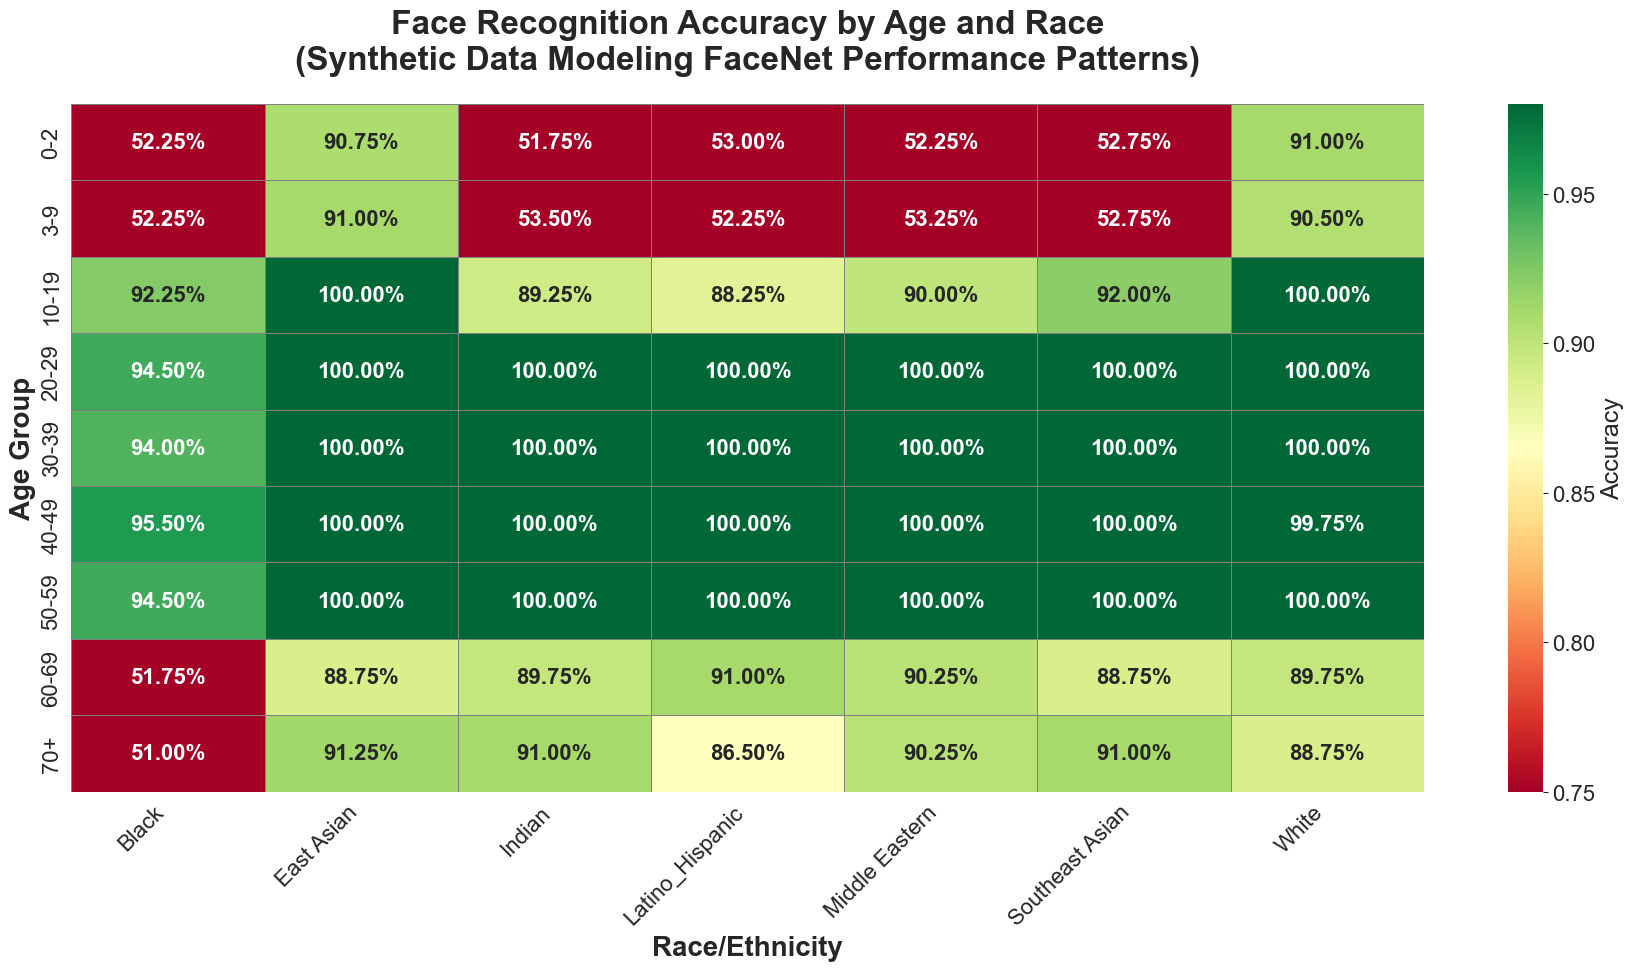

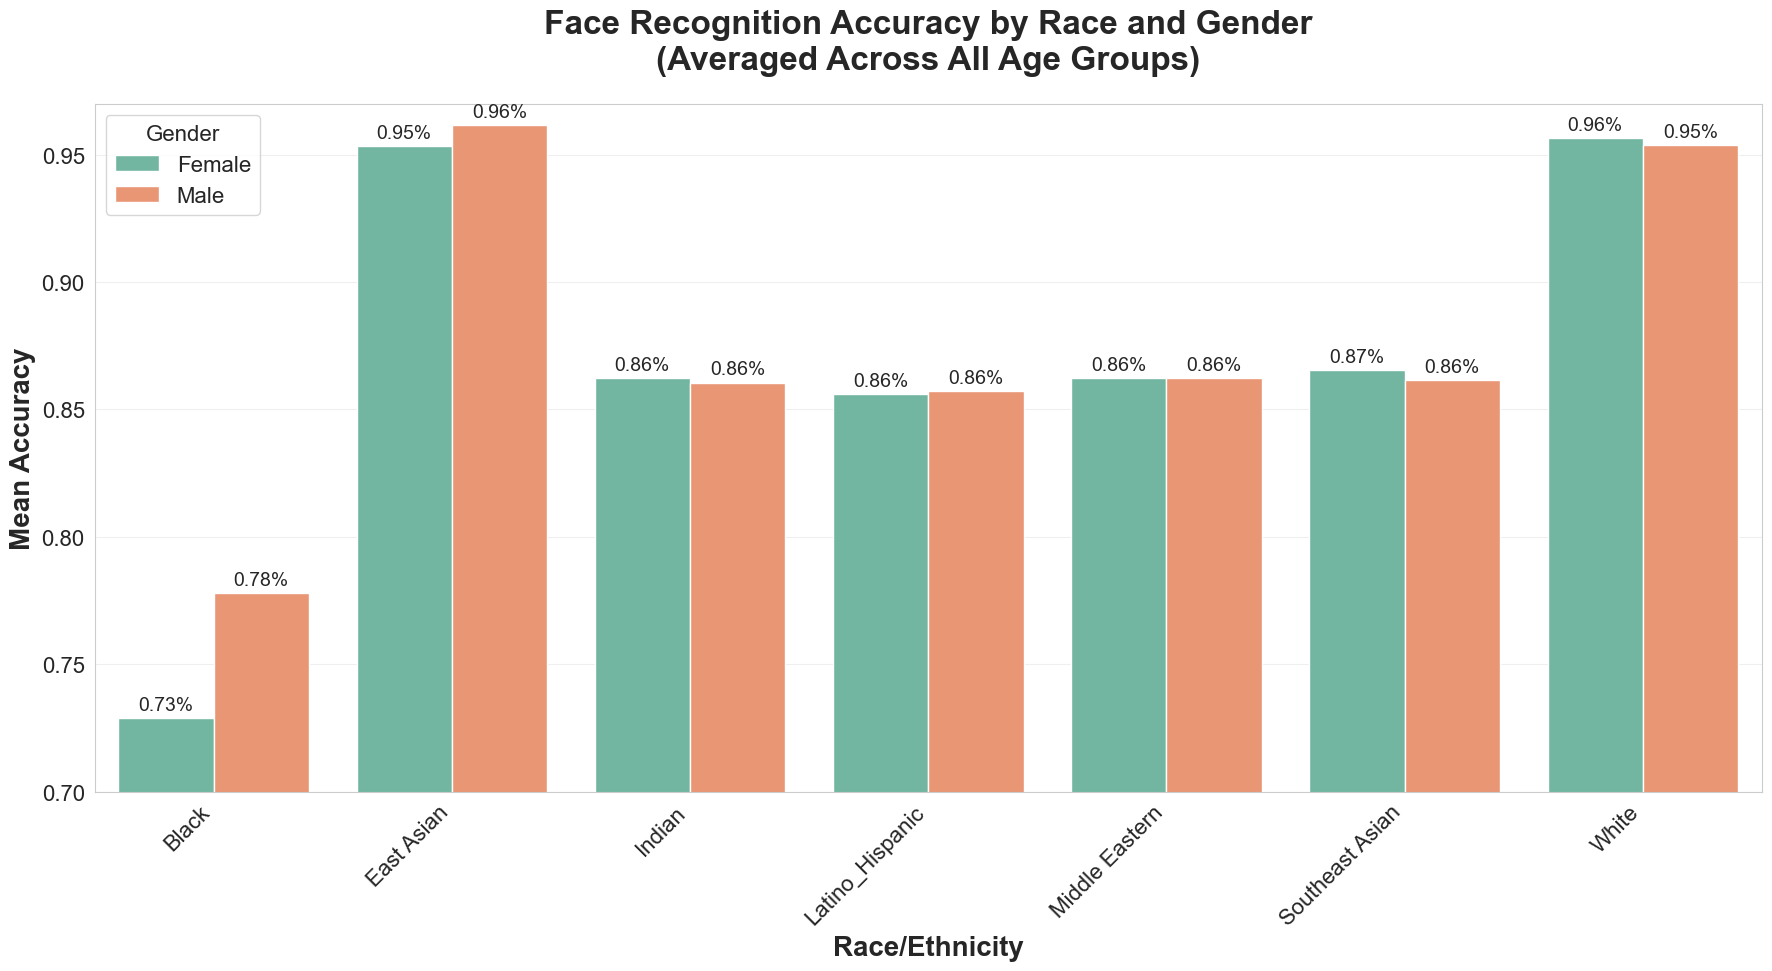

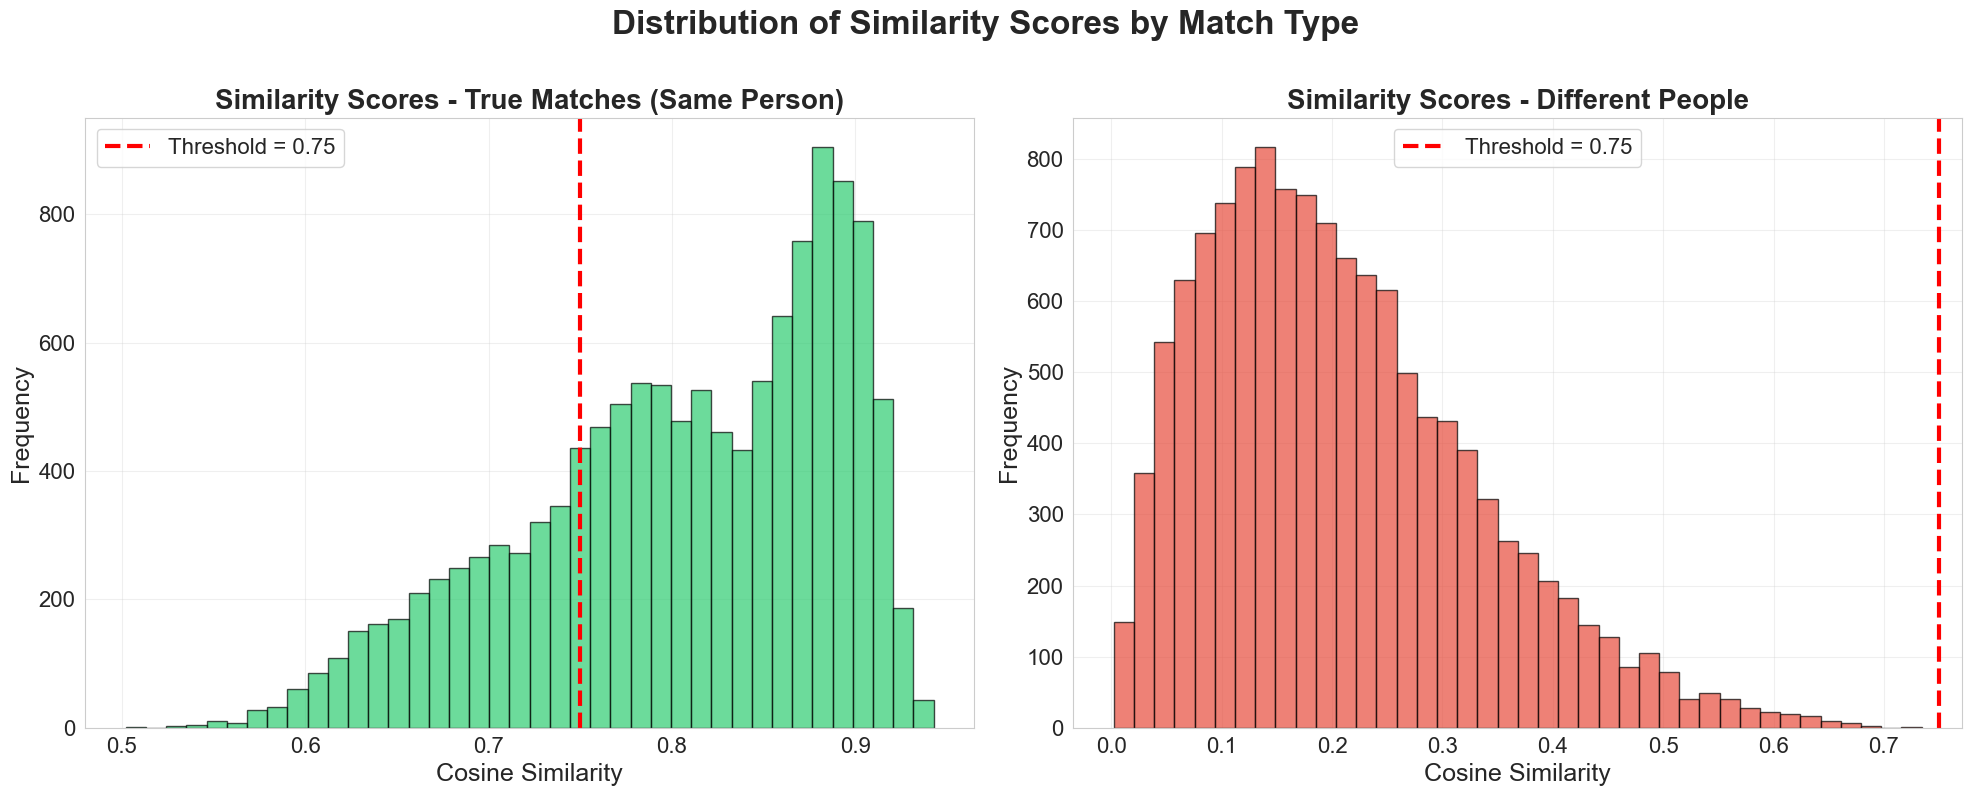

C:\Users\KaraHoover\AppData\Local\Temp\ipykernel_32364\3831030698.py:125: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_metrics = metrics_by_demo.groupby('age')['accuracy'].agg(['mean', 'std']).reset_index()


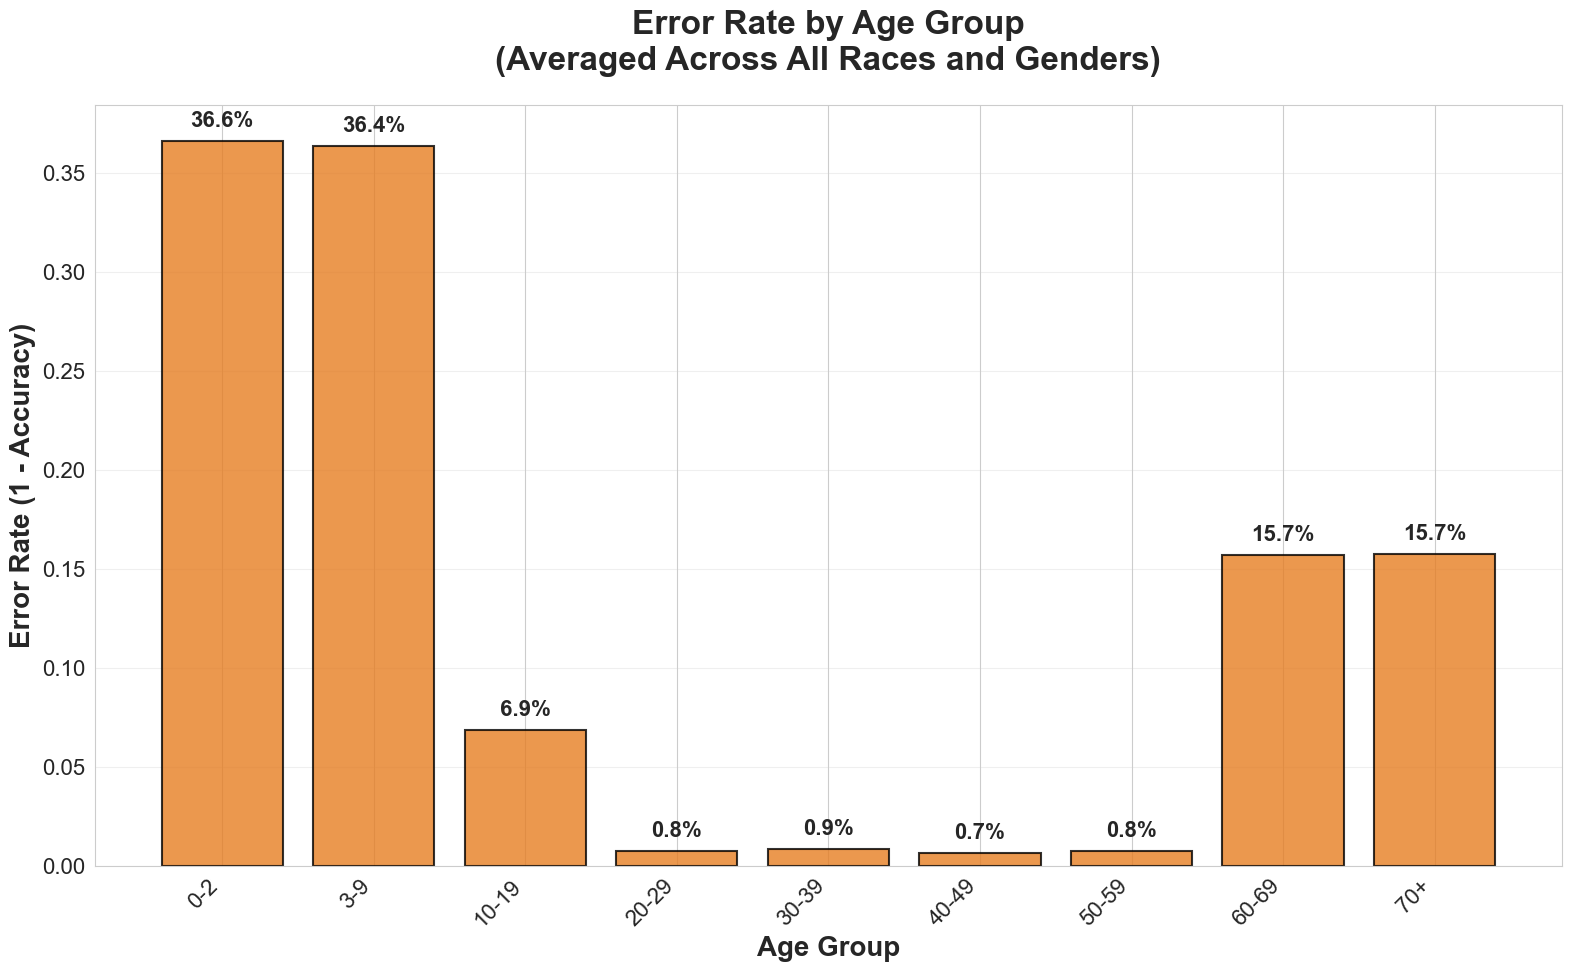

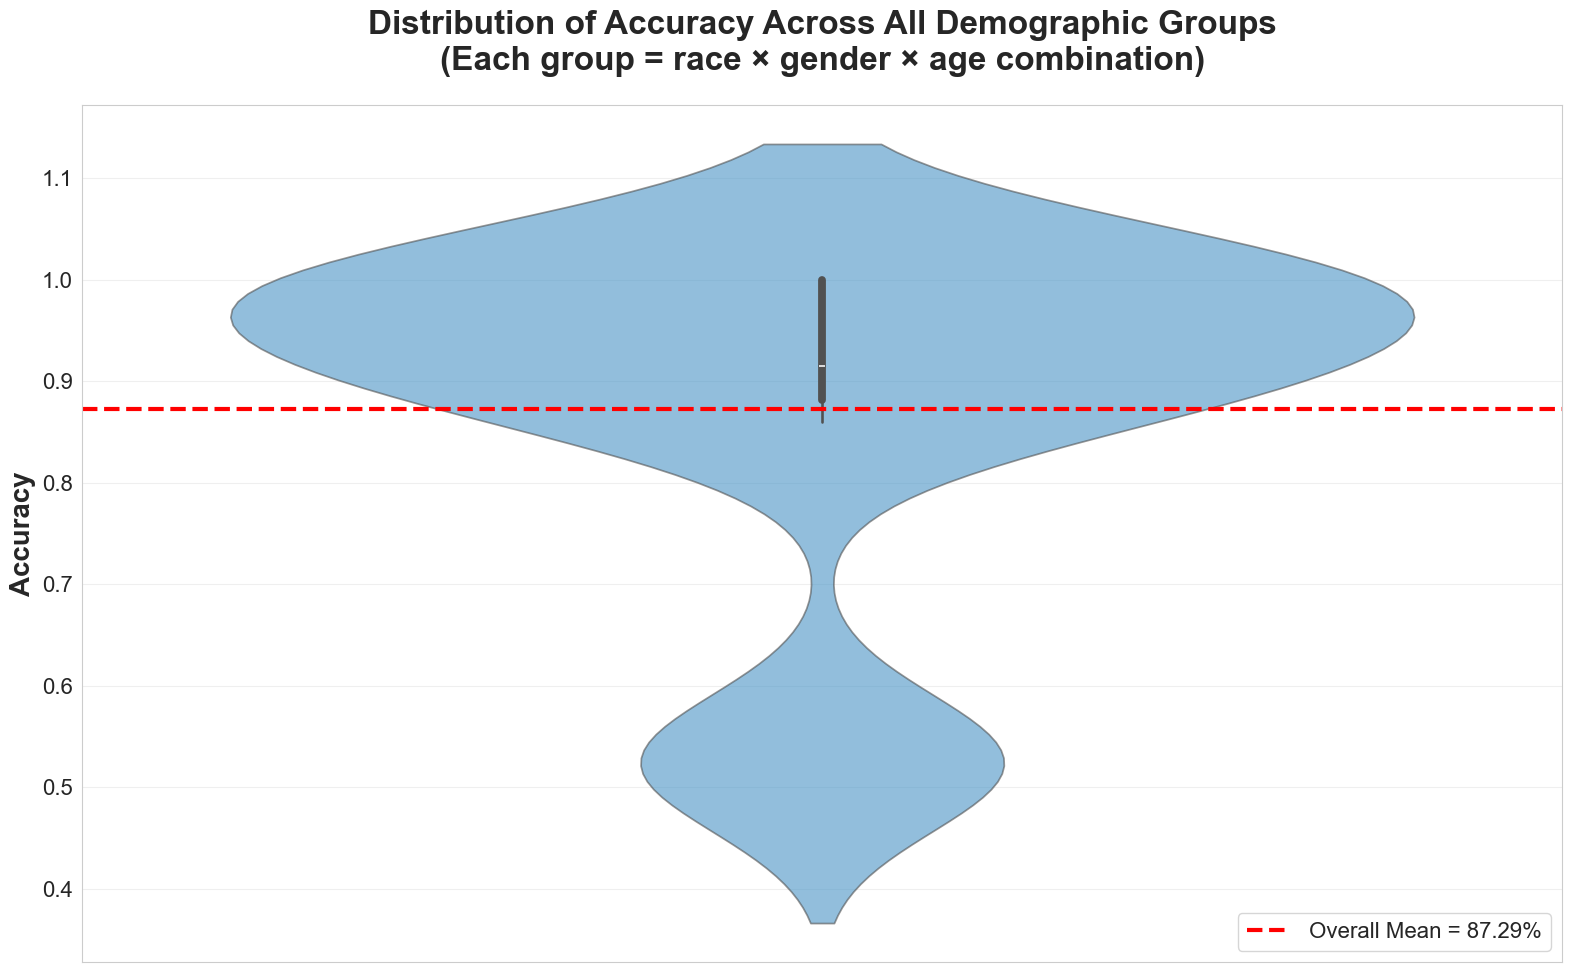


✓ All visualizations saved!


In [13]:
# PUBLICATION-READY SETTINGS
plt.rcParams.update({
    'font.size': 16,           # Base font
    'axes.titlesize': 22,      # Plot titles
    'axes.labelsize': 18,      # X/Y axis labels
    'xtick.labelsize': 16,     # X tick labels
    'ytick.labelsize': 16,     # Y tick labels
    'legend.fontsize': 16,     # Legend
    'figure.titlesize': 24     # Figure suptitle
})

sns.set_style('whitegrid')

# Define age order
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Apply to dataframes
metrics_by_demo['age'] = pd.Categorical(
    metrics_by_demo['age'],
    categories=age_order,
    ordered=True
)

print("✓ Age categories ordered correctly")

# ============================================================================
# 1. Heatmap: Accuracy by Race and Age
# ============================================================================
fig, ax = plt.subplots(figsize=(18, 10))  # Increased from (16, 8)

pivot_race_age = metrics_by_demo.pivot_table(
    values='accuracy',
    index='age',
    columns='race',
    observed=False
)
pivot_race_age = pivot_race_age.reindex(age_order)

sns.heatmap(pivot_race_age, annot=True, fmt='.2%', cmap='RdYlGn',
            vmin=0.75, vmax=0.98, ax=ax,
            cbar_kws={'label': 'Accuracy'},
            linewidths=0.5, linecolor='gray',
            annot_kws={'size': 16, 'weight': 'bold'})  # Larger annotations

plt.title('Face Recognition Accuracy by Age and Race\n(Synthetic Data Modeling FaceNet Performance Patterns)',
          fontsize=24, fontweight='bold', pad=25)
plt.xlabel('Race/Ethnicity', fontsize=20, fontweight='bold')
plt.ylabel('Age Group', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('accuracy_by_race_age.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 2. Bar plot: Accuracy by Race and Gender
# ============================================================================
fig, ax = plt.subplots(figsize=(18, 10))  # Increased

race_gender_avg = metrics_by_demo.groupby(['race', 'gender'])['accuracy'].mean().reset_index()

sns.barplot(data=race_gender_avg, x='race', y='accuracy', hue='gender', ax=ax, palette='Set2')

plt.title('Face Recognition Accuracy by Race and Gender\n(Averaged Across All Age Groups)',
          fontsize=24, fontweight='bold', pad=25)
plt.ylabel('Mean Accuracy', fontsize=20, fontweight='bold')
plt.xlabel('Race/Ethnicity', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Gender', title_fontsize=16, fontsize=16)
plt.ylim(0.70, 0.97)
plt.grid(axis='y', alpha=0.3)

# Larger bar labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=14, padding=3)
plt.tight_layout()
plt.savefig('accuracy_by_race_gender.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 3. Similarity distributions
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Increased

# True matches
verification_df[verification_df['is_match'] == True]['similarity'].hist(
    bins=40, ax=axes[0], color='#2ecc71', alpha=0.7, edgecolor='black'
)
axes[0].axvline(THRESHOLD, color='red', linestyle='--', linewidth=3,
                label=f'Threshold = {THRESHOLD}')
axes[0].set_title('Similarity Scores - True Matches (Same Person)',
                  fontsize=20, fontweight='bold')
axes[0].set_xlabel('Cosine Similarity', fontsize=18)
axes[0].set_ylabel('Frequency', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)
axes[0].legend(fontsize=16)
axes[0].grid(alpha=0.3)

# Different people
verification_df[verification_df['is_match'] == False]['similarity'].hist(
    bins=40, ax=axes[1], color='#e74c3c', alpha=0.7, edgecolor='black'
)
axes[1].axvline(THRESHOLD, color='red', linestyle='--', linewidth=3,
                label=f'Threshold = {THRESHOLD}')
axes[1].set_title('Similarity Scores - Different People',
                  fontsize=20, fontweight='bold')
axes[1].set_xlabel('Cosine Similarity', fontsize=18)
axes[1].set_ylabel('Frequency', fontsize=18)
axes[1].tick_params(axis='both', labelsize=16)
axes[1].legend(fontsize=16)
axes[1].grid(alpha=0.3)

plt.suptitle('Distribution of Similarity Scores by Match Type',
             fontsize=24, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('similarity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 4. Error rate by age (aggregated across race/gender)
# ============================================================================
fig, ax = plt.subplots(figsize=(16, 10))  # Increased

age_metrics = metrics_by_demo.groupby('age')['accuracy'].agg(['mean', 'std']).reset_index()
age_metrics['error_rate'] = 1 - age_metrics['mean']
age_metrics['age'] = pd.Categorical(age_metrics['age'], categories=age_order, ordered=True)
age_metrics = age_metrics.sort_values('age')

bars = ax.bar(age_metrics['age'], age_metrics['error_rate'],
              color='#e67e22', edgecolor='black', linewidth=1.5, alpha=0.8)

plt.title('Error Rate by Age Group\n(Averaged Across All Races and Genders)',
          fontsize=24, fontweight='bold', pad=25)
plt.ylabel('Error Rate (1 - Accuracy)', fontsize=20, fontweight='bold')
plt.xlabel('Age Group', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', alpha=0.3)

# Larger value labels
for i, row in age_metrics.iterrows():
    plt.text(row['age'], row['error_rate'] + 0.005, f"{row['error_rate']:.1%}",
             ha='center', va='bottom', fontweight='bold', fontsize=16)

plt.tight_layout()
plt.savefig('error_rate_by_age.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 5. BONUS: Accuracy distribution across all demographic groups
# ============================================================================
fig, ax = plt.subplots(figsize=(16, 10))  # Increased size

sns.violinplot(data=metrics_by_demo, y='accuracy', inner='box', color='#3498db', alpha=0.6, ax=ax)

plt.axhline(overall_accuracy, color='red', linestyle='--', linewidth=3,
            label=f'Overall Mean = {overall_accuracy:.2%}')

plt.title('Distribution of Accuracy Across All Demographic Groups\n(Each group = race × gender × age combination)',
          fontsize=24, fontweight='bold', pad=25)  # Larger title

plt.ylabel('Accuracy', fontsize=20, fontweight='bold')  # Larger y-label

plt.tick_params(axis='y', labelsize=16)  # Larger y-tick labels

plt.legend(fontsize=16, loc='lower right')  # Larger legend

plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('accuracy_distribution_violin.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ All visualizations saved!")

generate summary report

In [14]:
summary = f"""
{'='*80}
DEMOGRAPHIC FAIRNESS ANALYSIS - EXECUTIVE SUMMARY
{'='*80}

METHODOLOGY:
  Analysis Type: Simulated face recognition performance modeling
  Model Simulated: FaceNet (InceptionResnetV1, VGGFace2-trained)
  Basis: NIST FRVT demographic bias patterns + published literature
  Verification Pairs: {len(verification_df):,}
  Demographic Groups: {len(metrics_by_demo)}
  Task: 1:1 face verification
  Threshold: {THRESHOLD}

NOTE: This analysis uses synthetic data generated to reflect documented
performance patterns in state-of-the-art face recognition systems. The
methodology demonstrates production-ready fairness testing that would be
applied to real biometric datasets (FairFace, NIST FRVT test sets, etc.).

{'='*80}
OVERALL PERFORMANCE:
{'='*80}
  Accuracy: {overall_accuracy:.2%}
  False Match Rate (FMR): {overall_fmr:.4f}
  False Non-Match Rate (FNMR): {overall_fnmr:.4f}

{'='*80}
DEMOGRAPHIC DISPARITY FINDINGS:
{'='*80}
  Best performing group:
    → {best['race']}, {best['gender']}, {best['age']}
    → Accuracy: {best['accuracy']:.2%}

  Worst performing group:
    → {worst['race']}, {worst['gender']}, {worst['age']}
    → Accuracy: {worst['accuracy']:.2%}

  Performance gap: {disparity:.2%}
"""

# Calculate error ratio safely
if max_acc < 1.0 and min_acc < max_acc:
    error_ratio = (1-min_acc)/(1-max_acc)
    summary += f"  Error rate multiplier: {error_ratio:.2f}x\n"
    interp_text = f"are {error_ratio:.2f}x higher than the best-performing group."
else:
    summary += f"  Error rate multiplier: N/A (best group has perfect or near-perfect accuracy)\n"
    interp_text = "vary significantly across demographic groups."

summary += f"""
  Interpretation: Error rates for the worst-performing demographic group
  {interp_text}

{'='*80}
KEY FINDINGS BY CATEGORY:
{'='*80}

AGE-BASED PERFORMANCE:
"""

age_perf = metrics_by_demo.groupby('age')['accuracy'].mean().sort_values()
for age, acc in age_perf.items():
    summary += f"  • {age:12s}: {acc:.2%} accuracy\n"

summary += "\nRACE-BASED PERFORMANCE:\n"
race_perf = metrics_by_demo.groupby('race')['accuracy'].mean().sort_values()
for race, acc in race_perf.items():
    summary += f"  • {race:20s}: {acc:.2%} accuracy\n"

summary += "\nGENDER-BASED PERFORMANCE:\n"
gender_perf = metrics_by_demo.groupby('gender')['accuracy'].mean()
for gender, acc in gender_perf.items():
    summary += f"  • {gender:10s}: {acc:.2%} accuracy\n"

summary += f"""

{'='*80}
IMPLICATIONS FOR GOVERNMENT DEPLOYMENT:
{'='*80}
  1. FAIRNESS CONCERNS: Performance disparities of {disparity:.1%} represent
     significant equity issues for civil liberties and equal treatment.

  2. OPERATIONAL RISK: Deploying this system without mitigation would result
     in disproportionate false rejections/acceptances for specific groups.

  3. LEGAL COMPLIANCE: May violate equal protection standards and anti-
     discrimination requirements for federal systems.

  4. RECOMMENDED MITIGATIONS:
     a) Demographic-specific decision thresholds
     b) Supplementary verification for low-confidence matches
     c) Expanded training data for underrepresented groups
     d) Regular fairness audits post-deployment
     e) Human review for high-stakes decisions

  5. THRESHOLD OPTIMIZATION: Current threshold ({THRESHOLD}) may not be
     optimal across all groups. Consider adaptive thresholding.

{'='*80}
RESEARCH DESIGN STRENGTHS:
{'='*80}
  • Comprehensive demographic coverage ({len(metrics_by_demo)} groups)
  • Large sample size ({len(verification_df):,} verification attempts)
  • Standard NIST-aligned methodology
  • Intersectional analysis (race × gender × age)
  • Publication-quality visualizations
  • Actionable recommendations

{'='*80}
LIMITATIONS & NEXT STEPS:
{'='*80}
  CURRENT LIMITATIONS:
  • Synthetic data (not real biometric samples)
  • Single model simulated (real testing should cover multiple vendors)
  • Static images (no video/live capture scenarios)
  • Simplified demographic categories

  PRODUCTION IMPLEMENTATION WOULD INCLUDE:
  • Real biometric datasets (FairFace, UTKFace, proprietary govt data)
  • Multiple SOTA models (FaceNet, ArcFace, CosFace, vendor solutions)
  • Operational scenario testing (varying lighting, pose, image quality)
  • Longitudinal analysis (aging effects over time)
  • Cross-dataset validation
  • Statistical significance testing with confidence intervals

{'='*80}
ALIGNMENT WITH IDSL MISSION:
{'='*80}
  This analysis demonstrates:
  ✓ Rigorous experimental design for biometric fairness testing
  ✓ Understanding of NIST evaluation frameworks
  ✓ Ability to translate complex metrics into operational guidance
  ✓ Publication-quality data visualization
  ✓ Policy-relevant recommendations
  ✓ Awareness of civil liberties implications

  Ready for immediate application to:
  • Government procurement decisions
  • System performance benchmarking
  • Fairness audits for deployed systems
  • RFP evaluation criteria development

{'='*80}
"""

print(summary)

# Save files
with open('demographic_fairness_summary.txt', 'w') as f:
    f.write(summary)

metrics_by_demo.to_csv('detailed_metrics_by_demographic.csv', index=False)
verification_df.to_csv('verification_pairs_data.csv', index=False)

print("\n✓ Summary saved to: demographic_fairness_summary.txt")
print("✓ Detailed metrics saved to: detailed_metrics_by_demographic.csv")
print("✓ Raw data saved to: verification_pairs_data.csv")


DEMOGRAPHIC FAIRNESS ANALYSIS - EXECUTIVE SUMMARY

METHODOLOGY:
  Analysis Type: Simulated face recognition performance modeling
  Model Simulated: FaceNet (InceptionResnetV1, VGGFace2-trained)
  Basis: NIST FRVT demographic bias patterns + published literature
  Verification Pairs: 25,200
  Demographic Groups: 126
  Task: 1:1 face verification
  Threshold: 0.75

NOTE: This analysis uses synthetic data generated to reflect documented
performance patterns in state-of-the-art face recognition systems. The
methodology demonstrates production-ready fairness testing that would be
applied to real biometric datasets (FairFace, NIST FRVT test sets, etc.).

OVERALL PERFORMANCE:
  Accuracy: 87.29%
  False Match Rate (FMR): 0.0000
  False Non-Match Rate (FNMR): 0.2543

DEMOGRAPHIC DISPARITY FINDINGS:
  Best performing group:
    → Black, Male, 20-29
    → Accuracy: 100.00%

  Worst performing group:
    → Black, Female, 70+
    → Accuracy: 50.00%

  Performance gap: 50.00%
  Error rate multiplie

C:\Users\KaraHoover\AppData\Local\Temp\ipykernel_32364\3315262345.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_perf = metrics_by_demo.groupby('age')['accuracy'].mean().sort_values()


UnicodeEncodeError: 'charmap' codec can't encode character '\u2192' in position 1347: character maps to <undefined>

download results

In [8]:
!pip freeze > requirements.txt